# 梯度提升树的袋外数据

在讲解梯度提升树的基本原理时，我们提到梯度提升树结合了Boosting和Bagging中的重要思想。受到随机森林的启发，梯度提升树在每次建树之前，也允许模型对于数据和特征进行随机有放回抽样，构建与原始数据集相同数据量的自助集。在梯度提升树的原理当中，当每次建树之前进行随机抽样时，这种梯度提升树叫做随机提升树(Stochastic Gradient Boosting)。相比起传统的梯度提升树，随机提升树输出的结果往往方差更低，但偏差略高。如果我们发现GBDT的结果高度不稳定，则可以尝试使用随机提升树。

在GBDT当中，对数据的随机有放回抽样比例由参数subsample确定，当该参数被设置为1时，则不进行抽样，直接使用全部数据集进行训练。当该参数被设置为(0,1)之间的数字时，则使用随机提升树，在每轮建树之前对样本进行抽样。对特征的有放回抽样比例由参数ma×_features确定，随机模式则由参数random_state确定，这两个参数在GBDT当中的使用规则都与随机森林中完全一致。

需要注意的是，如果subsample < 1,即存在有放回随机抽样时，当数据量足够大、抽样次数足够多时，大约会有37%的数据被遗漏在“袋外”(out of bag)没有参与训练。在随机森林课程当中，我们详细地证明了37%的由来，并且使用这37%的袋外数据作为验证数据，对随机森林的结果进行验证。在GBDT当中，当有放回随机抽样发生时，自然也存在部分袋外数据没有参与训练。这部分数据在GBDT中被用于对每一个弱评估器的建立结果进行验证。

具体地来说，每建立一棵树，GBDT就会使用当前树的袋外数据对建立新树后的模型进行验证，以此来对比新建弱评估器后模型整体的水平是否提高，并保留提升或下降的结果。这个过程相当于在GBDT迭代时，不断检验损失函数的值并捕捉其变化的趋势。在GBDT当中，这些袋外分数的变化值被储存在属性oob_improvement_中，同时，GBDT还会在每棵树的训练数据上保留袋内分数(in-bag)的变化，且储存在属性train_score当中。也就是说，即便在不做交叉验证的情况下，我们也可以简单地通过属性oob_improvement与属性train_score_来观察GBDT送代的结果。我们来看具体的例子：

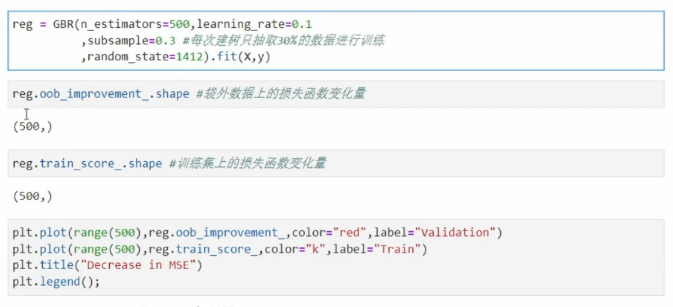

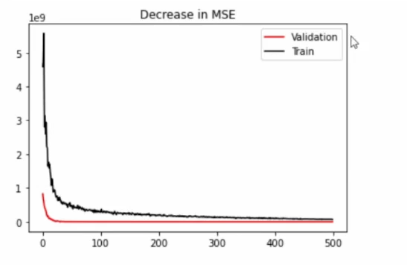

不难发现，随着迭代次数的增加，训川练集上的损失函数一直有下降量，虽然下降量在逐渐变小，但是损失函数的确是在持续减下降的，相对的，验证集上的结果则在少有波动之后就维持在0附近不动了，也就是说模型的泛化能力在很早的时候就预见了瓶颈。如果我们开启提前停止，恐怕实际的迭代次数会远远少于我们给与的500次：

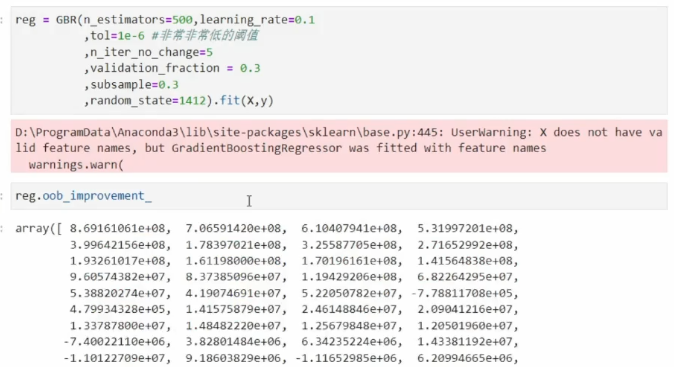

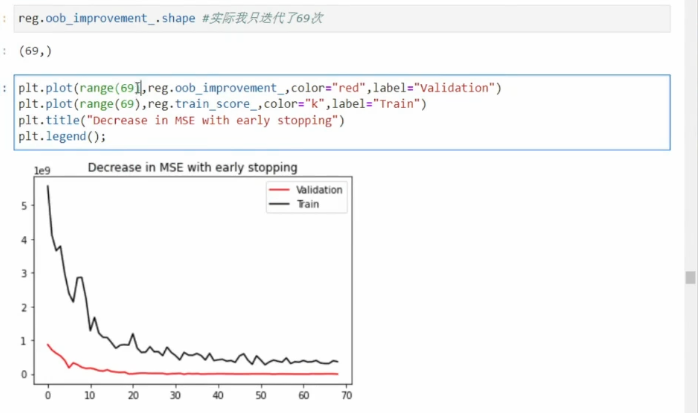

不难发现，袋外数据的设置可以帮助我们快速把握模型的迭代情况，在当前数据集上，设置大约50以下的迭代次数，就足够使用了。因此在我们对GBDT进行超参数调优时我们也有了天然的n_estimators的范围设置。当然，当我们调整其他参数(如learning rate或者max_depth)之后，n estimators的范围可能受到影响，但我们已经有了50这个可以参考的点。

奇怪的是，袋外数据是天然的验证数据，而坭前停止时需要使用验证集的功能，但sklearn中并未配置直接使用袋外数据来进行提前停止的功能。如果能够使用袋外数据进行提前停止，则可以使用更多数据进行训练，这将会更加有利于模型的学习。

总结一下，与弱分类器训练数据相关的参数有：

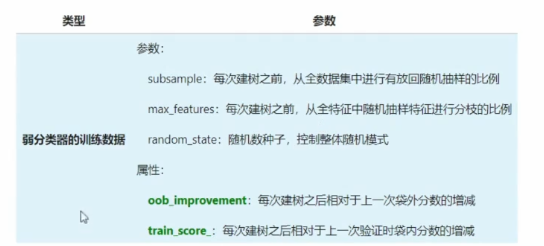

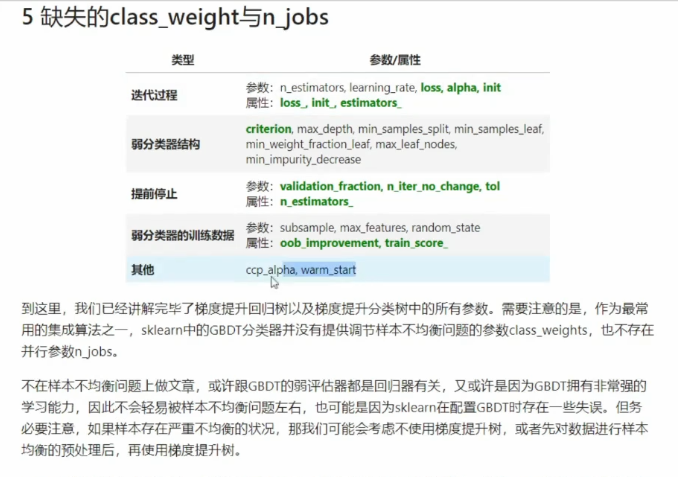

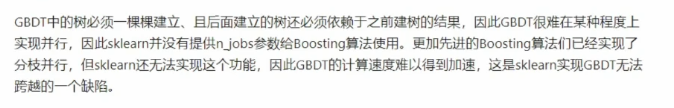